In [3]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths
train_csv_path = "/Users/ankitsanjyal/Desktop/Projects/Portfolio/AI-REAL-IMAGES-DATA/train.csv"  
train_images_path = "/Users/ankitsanjyal/Desktop/Projects/Portfolio/AI-REAL-IMAGES-DATA/"  

# Load train.csv
df_train = pd.read_csv(train_csv_path)

df_train["image_path"] = df_train["file_name"].apply(lambda x: os.path.join(train_images_path, x))
df_train.head()



,Unnamed: 0,file_name,label,image_path
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0,/Users/ankitsanjyal/Desktop/Projects/Portfolio...
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1,/Users/ankitsanjyal/Desktop/Projects/Portfolio...


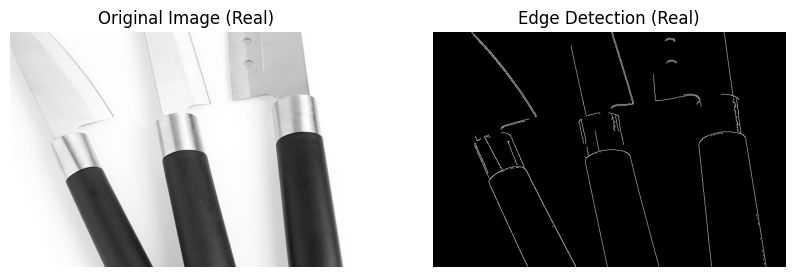

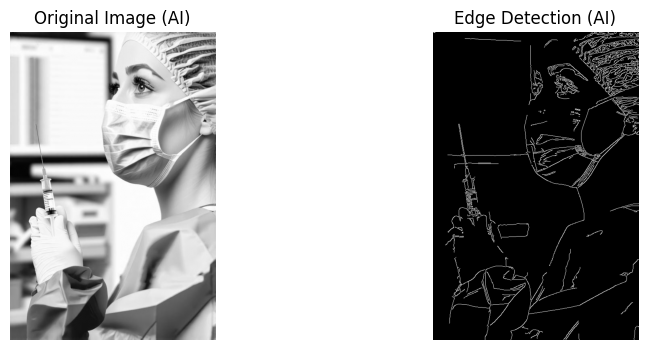

In [18]:

df_train["label"] = df_train["label"].replace({0: "Real", 1: "AI"})

def apply_edge_detection(image_path, label):
    """Apply Canny edge detection and display original & edge-detected images."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return

    # Apply Canny Edge Detection
    edges = cv2.Canny(img, 100, 200)  # Adjust thresholds as needed

    # Plot Original vs. Edge-Detected Image
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Original Image ({label})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap="gray")
    plt.title(f"Edge Detection ({label})")
    plt.axis("off")

    plt.show()

# Select a random real and AI-generated image
sample_real = df_train[df_train["label"] == "Real"]["image_path"].sample(1).values[0]
sample_ai = df_train[df_train["label"] == "AI"]["image_path"].sample(1).values[0]

# Apply edge detection
apply_edge_detection(sample_real, "Real")
apply_edge_detection(sample_ai, "AI")

Can't see much difference from the naked eyes

In [9]:
def count_edges(image_path):
    """Return the number of edge pixels in an image."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return 0

    edges = cv2.Canny(img, 100, 200)
    return np.sum(edges > 0)  # Count nonzero (edge) pixels

# Compute edge densities for Real and AI images
df_train["edge_count"] = df_train["image_path"].apply(count_edges)

# Calculate average edge density for both classes
edge_stats = df_train.groupby("label")["edge_count"].mean()
print(edge_stats)


label
AI      30526.796448
Real    29276.001976
Name: edge_count, dtype: float64


## Result:
* AI images have mean edge count greater than real images (not small as it's the average)
* That means AI-generated images might be more defined or artificial looking edges compared to real images

## Possible interpretation:
* AI images might have sharper or more pronounced edges
    * AI models often generate crisper or more exaggerated details, especially if they are trained to enhance clarity
    * That could mean AI-generated images have more structured lines and defined boundaries than real images
* Real images might have more natural transitions
    * In real-world images, lighting, shadows and textures create softer edges with gradual intensity changes
    * Real photos include factors like motion blur, depth of field, and natural noise, which can reduce the number of detected edges
* AI-generated images may rely on different rendering techniques
    * If ai model generating these images focuses on sharpening contours like in GANs, the result could be an increased edge count

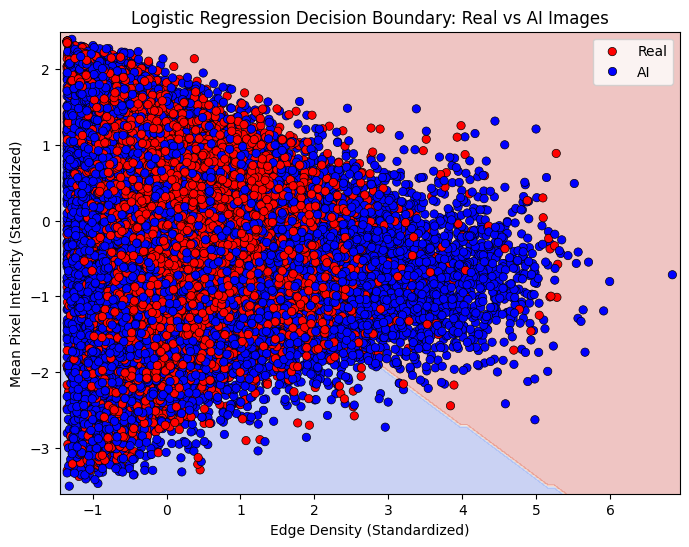

In [10]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Function to compute edge density and mean intensity
def compute_features(image_paths, labels):
    data = {"label": [], "edge_density": [], "mean_intensity": []}
    
    for img_path, label in zip(image_paths, labels):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        if img is None:
            continue
        
        # Compute edges using Canny edge detection
        edges = cv2.Canny(img, 100, 200)
        edge_count = np.sum(edges > 0)  # Count nonzero pixels (edges)
        total_pixels = img.shape[0] * img.shape[1]  # Total pixels
        edge_density = edge_count / total_pixels if total_pixels > 0 else 0
        
        # Compute mean pixel intensity
        mean_intensity = np.mean(img)
        
        # Store in data
        data["label"].append(label)
        data["edge_density"].append(edge_density)
        data["mean_intensity"].append(mean_intensity)
    
    return pd.DataFrame(data)

# Extract file paths and labels
image_paths = df_train["image_path"].values
labels = df_train["label"].values  # 0 = Real, 1 = AI

# Compute features
df_features = compute_features(image_paths, labels)

# Convert labels to numeric
df_features["label"] = df_features["label"].map({"Real": 0, "AI": 1})

# Prepare data for logistic regression
X = df_features[["edge_density", "mean_intensity"]]
y = df_features["label"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train logistic regression model
clf = LogisticRegression()
clf.fit(X_scaled, y)

# Generate mesh grid for decision boundary
x_min, x_max = X_scaled[:, 0].min() - 0.1, X_scaled[:, 0].max() + 0.1
y_min, y_max = X_scaled[:, 1].min() - 0.1, X_scaled[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df_features["label"], palette=["blue", "red"], edgecolor="k")

# Labels and title
plt.xlabel("Edge Density (Standardized)")
plt.ylabel("Mean Pixel Intensity (Standardized)")
plt.title("Logistic Regression Decision Boundary: Real vs AI Images")
plt.legend(["Real", "AI"])
plt.show()


Looks like The features doesn't have much meaning afterall

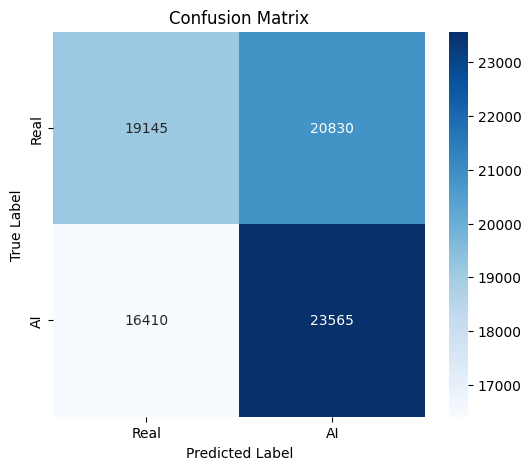

Classification Report:
               precision    recall  f1-score   support

        Real       0.54      0.48      0.51     39975
          AI       0.53      0.59      0.56     39975

    accuracy                           0.53     79950
   macro avg       0.53      0.53      0.53     79950
weighted avg       0.53      0.53      0.53     79950



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict labels on the training set
y_pred = clf.predict(X_scaled)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "AI"], yticklabels=["Real", "AI"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y, y_pred, target_names=["Real", "AI"]))


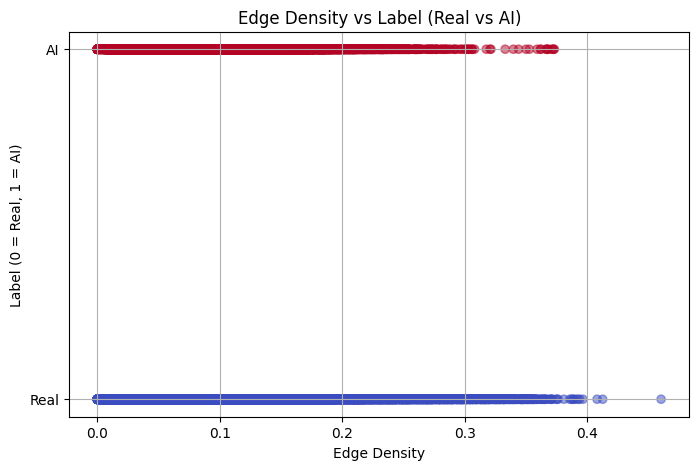

In [15]:
# Scatter plot of edge density vs label
plt.figure(figsize=(8, 5))
plt.scatter(df_features["edge_density"], df_features["label"], alpha=0.5, c=df_features["label"], cmap="coolwarm")

# Customizing the plot
plt.xlabel("Edge Density")
plt.ylabel("Label (0 = Real, 1 = AI)")
plt.title("Edge Density vs Label (Real vs AI)")
plt.yticks([0, 1], ["Real", "AI"])
plt.grid(True)
plt.show()

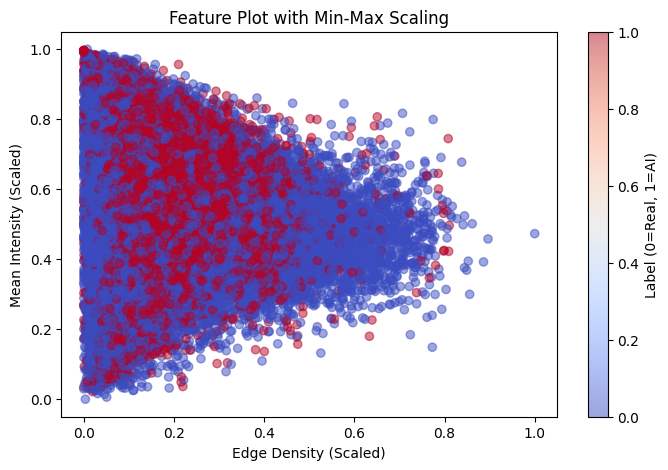

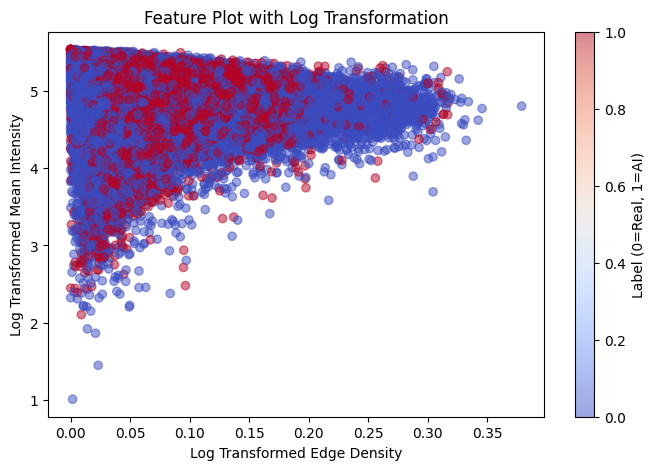

In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Extract features
X = df_features[['edge_density', 'mean_intensity']]
y = df_features['label']  # Assuming 0 = Real, 1 = AI

# Apply Min-Max Scaling
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)

# Apply Standardization
standard_scaler = StandardScaler()
X_standard = standard_scaler.fit_transform(X)

# Apply Log Transformation
X_log = np.log1p(X)  # log(1 + x) to avoid log(0) issues

# Apply Square Root Transformation
X_sqrt = np.sqrt(X)

# Plot scaled features (Min-Max Scaling)
plt.figure(figsize=(8, 5))
plt.scatter(X_minmax[:, 0], X_minmax[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('Edge Density (Scaled)')
plt.ylabel('Mean Intensity (Scaled)')
plt.title('Feature Plot with Min-Max Scaling')
plt.colorbar(label="Label (0=Real, 1=AI)")
plt.show()

# Plot transformed features (Log Transformation)
plt.figure(figsize=(8, 5))
plt.scatter(X_log['edge_density'], X_log['mean_intensity'], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('Log Transformed Edge Density')
plt.ylabel('Log Transformed Mean Intensity')
plt.title('Feature Plot with Log Transformation')
plt.colorbar(label="Label (0=Real, 1=AI)")
plt.show()


Feature engineering and feature transformation also couldn't explain much things.


I am leaving edge_density right here and moving to some other eploration